In [78]:
import pandas as pd
import numpy as np 
data_path =  {'test':'../data/test.csv', 'train':'../data/train.csv'}

In [79]:
df = pd.read_csv(data_path['test'],index_col=0)

In [80]:
df.head()

,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
6,https://api.github.com/repos/tlnagy/TIFF.jl/is...,enhancement,2020-04-07T09:08:50Z,NONE,https://api.github.com/repos/tlnagy/TIFF.jl,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0...",One more error might need to be caught.\r\n`4D...
19,https://api.github.com/repos/tisboyo/Twitch_Bo...,enhancement,2020-11-27T07:17:21Z,OWNER,https://api.github.com/repos/tisboyo/Twitch_Bot,Add database backup to dropbox,NaN
25,https://api.github.com/repos/DrWhoCares/imgdan...,enhancement,2021-01-02T19:35:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Add a button/method to open the Source or Outp...,Could also add a method to open up path to eac...
30,https://api.github.com/repos/DrWhoCares/imgdan...,bug,2021-01-02T20:55:34Z,OWNER,https://api.github.com/repos/DrWhoCares/imgdanke,Processes are being started twice,At some point I refactored a few things and en...
54,https://api.github.com/repos/Bean-1/AOT/issues/3,bug,2020-12-29T15:34:35Z,OWNER,https://api.github.com/repos/Bean-1/AOT,Cannot add hp to wall,NaN


In [81]:
for col in df.columns:
    print(col)

issue_url
issue_label
issue_created_at
issue_author_association
repository_url
issue_title
issue_body


In [82]:
df.shape

(80518, 7)

In [83]:
df.describe()

,issue_url,issue_label,issue_created_at,issue_author_association,repository_url,issue_title,issue_body
count,80518,80518,80518,80518,80518,80518,72602
unique,80138,3,79974,5,37817,78322,71192
top,https://api.github.com/repos/iftg7n/Test/issue...,bug,2021-01-07T20:42:46Z,NONE,https://api.github.com/repos/libsdl-org/SDL,Updates for Hero Section,TBD
freq,8,40288,11,30543,338,61,224


In [84]:
set(df.issue_author_association)

{'COLLABORATOR', 'CONTRIBUTOR', 'MEMBER', 'NONE', 'OWNER'}

In [85]:
df.issue_author_association.value_counts()

NONE            30543
OWNER           17986
CONTRIBUTOR     12522
MEMBER           9843
COLLABORATOR     9624
Name: issue_author_association, dtype: int64

In [86]:
df.issue_label.value_counts()

bug            40288
enhancement    33203
question        7027
Name: issue_label, dtype: int64

# Extract Repo Author, Repo Name and Issue number from URL

In [113]:
def process_urls(repo_url, issue_url):
    from urllib.parse import urlparse
    author = []
    repo = []
    issue_number = []
    for iss_url,rep_url in zip(issue_url,repo_url):
        assert iss_url.startswith(rep_url)
        parsed_url = urlparse(iss_url)
        url_path = parsed_url.path.split('/')
        auth, repo_name, _ ,iss_n = url_path[-4:]
        author.append(auth)
        repo.append(repo_name)
        issue_number.append(int(iss_n))
    return repo, author, issue_number

# Add above extracted extra columns to original data

In [114]:
modified_df = {'repository':[], 'repo_author':[], 'issue_number':[]}
rep, auth, iss = process_urls(df.repository_url, df.issue_url)

modified_df['repository'] = rep
modified_df['repo_author'] = auth
modified_df['issue_number'] = iss

modified_df = pd.DataFrame(modified_df)
modified_df['issue_label'] = df.issue_label.tolist()
modified_df['issue_author_association'] = df.issue_author_association.tolist()
modified_df['issue_title'] = df.issue_title.tolist()
modified_df['issue_body'] = df.issue_body.tolist()

In [115]:
modified_df.head()

,repository,repo_author,issue_number,issue_label,issue_author_association,issue_title,issue_body
0,TIFF.jl,tlnagy,7,enhancement,NONE,"ERROR: KeyError: key (TIFF.SAMPLEFORMAT_INT, 0...",One more error might need to be caught.\r\n`4D...
1,Twitch_Bot,tisboyo,57,enhancement,OWNER,Add database backup to dropbox,NaN
2,imgdanke,DrWhoCares,70,enhancement,OWNER,Add a button/method to open the Source or Outp...,Could also add a method to open up path to eac...
3,imgdanke,DrWhoCares,72,bug,OWNER,Processes are being started twice,At some point I refactored a few things and en...
4,AOT,Bean-1,3,bug,OWNER,Cannot add hp to wall,NaN


In [91]:
df.issue_created_at[:10] #Leave this for now, if issue number helps in classification then this might also be useful.

6      2020-04-07T09:08:50Z
19     2020-11-27T07:17:21Z
25     2021-01-02T19:35:34Z
30     2021-01-02T20:55:34Z
54     2020-12-29T15:34:35Z
62     2016-06-18T09:14:04Z
104    2021-01-02T22:23:54Z
113    2020-10-11T20:25:04Z
115    2018-05-04T13:51:50Z
161    2020-12-31T05:28:38Z
Name: issue_created_at, dtype: object

# Hypothesis : Issue number affects issue label

In [125]:
modified_df[modified_df['issue_number'] < 50].issue_label.value_counts()

enhancement    16611
bug             9698
question        1361
Name: issue_label, dtype: int64

In [129]:
modified_df[(modified_df['issue_number'] > 50) & (modified_df['issue_number'] < 200) ].issue_label.value_counts()

bug            7625
enhancement    7021
question       1303
Name: issue_label, dtype: int64

In [127]:
modified_df.issue_label.value_counts()

bug            40288
enhancement    33203
question        7027
Name: issue_label, dtype: int64

### Distribution of labels depends on when the issue was opened - early issues ask for enhancement, later issues report bugs.

# Plot length distributions for issue body and title

In [ ]:
word_length_body = modified_df.issue_body.apply(lambda x: len(x.split()) if type(x)!=float else 0)

/home/shikharb/miniconda3/envs/tree/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='issue_body'>

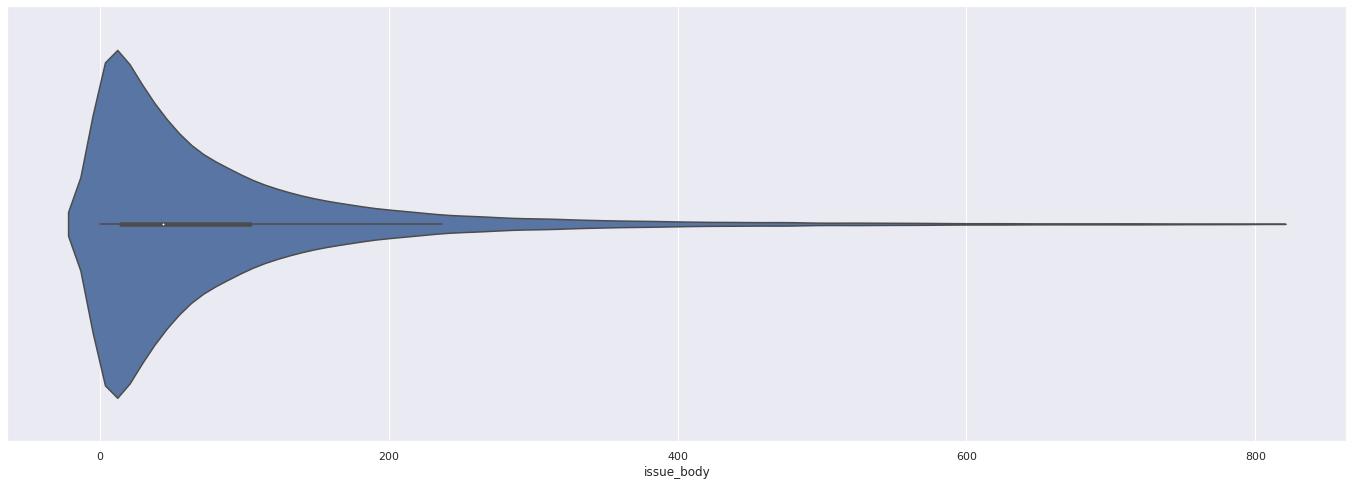

In [160]:
import seaborn as sns
sns.set(rc={'figure.figsize':(24,8)})
sns.violinplot(word_length_body[word_length_body<800]) 

In [162]:
word_length_body.describe()

count    80518.000000
mean        99.624121
std        329.431910
min          0.000000
25%         15.000000
50%         45.000000
75%        107.000000
max      21522.000000
Name: issue_body, dtype: float64

In [183]:
model_size = 512
word_length_body[word_length_body < model_size].count() / len(word_length_body) 
# ~98% bodies can be covered with seq len of 512. No specific need to focus on models that process longer sequences- simple BERT etc might work well.

0.9790978414764401

### ~98% bodies can be covered with seq len of 512. No specific need to focus on models that process longer sequences- simple BERT etc might work well.

In [172]:
from nltk.tokenize import sent_tokenize
sent_length_body = modified_df.issue_body.apply(lambda x: len(sent_tokenize(x)) if type(x)!=float else 0)

/home/shikharb/miniconda3/envs/tree/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='issue_body'>

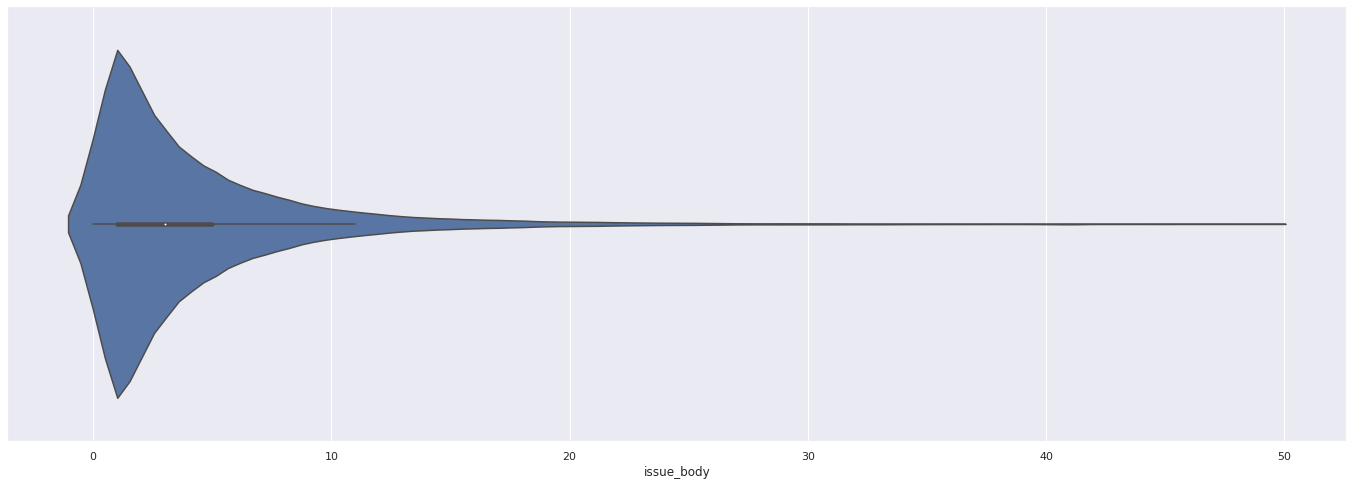

In [178]:
sns.violinplot(sent_length_body[sent_length_body < 50])

In [179]:
sent_length_body.describe()

count    80518.000000
mean         4.502223
std         12.851075
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1837.000000
Name: issue_body, dtype: float64

/home/shikharb/miniconda3/envs/tree/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='issue_title'>

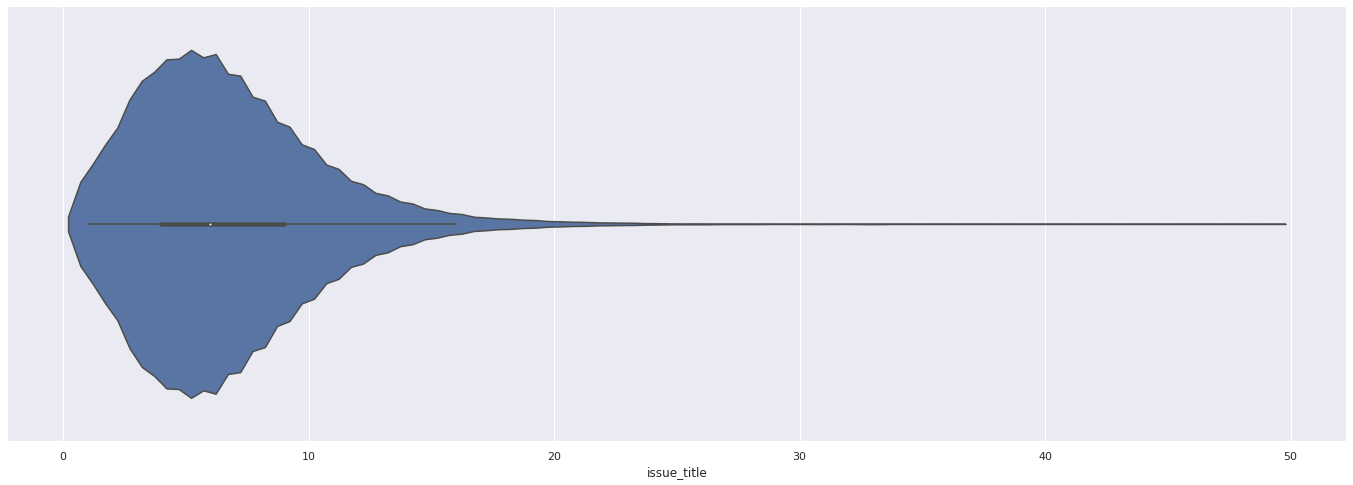

In [187]:
word_length_title = modified_df.issue_title.apply(lambda x: len(x.split()) if type(x)!=float else 0)
sns.violinplot(word_length_title[word_length_title<50])

In [188]:
word_length_title.describe()

count    80518.000000
mean         6.698353
std          3.872237
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max        104.000000
Name: issue_title, dtype: float64

### 50 seems to be a good cutoff for title length

In [195]:
sent_length_title = modified_df.issue_title.apply(lambda x: len(sent_tokenize(x)) if type(x)!=float else 0)

/home/shikharb/miniconda3/envs/tree/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='issue_title'>

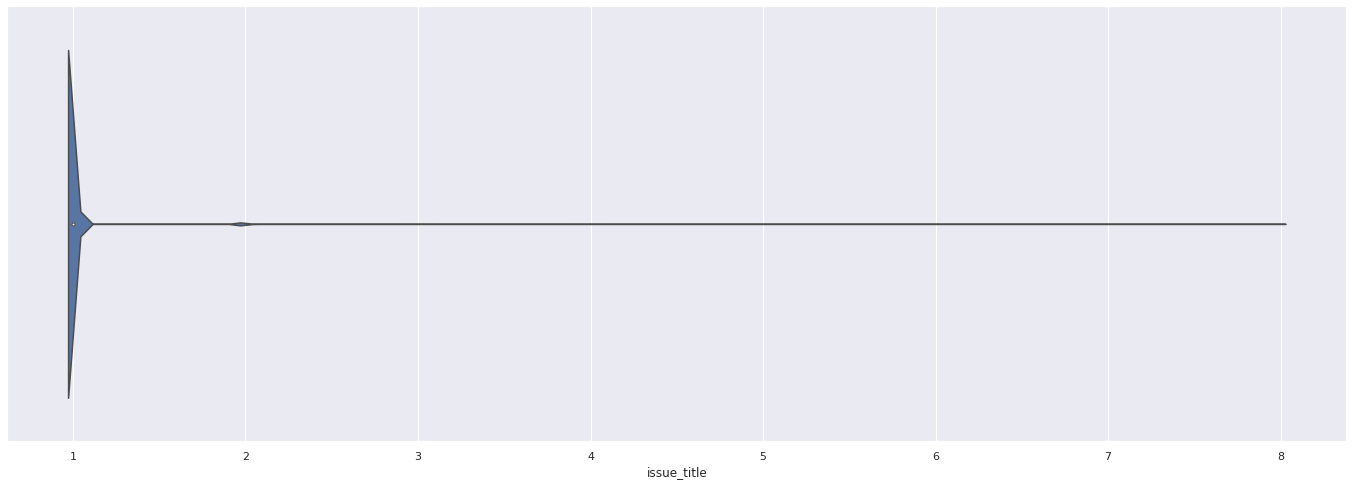

In [197]:
sns.violinplot(sent_length_title[sent_length_title<10])

In [198]:
sent_length_title.describe()

count    80518.000000
mean         1.014084
std          0.135304
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: issue_title, dtype: float64

# Lengths by labels

In [201]:
for category in ['bug','enhancement','question']:
    l_word_length_body = modified_df[modified_df['issue_label']==category].issue_body.apply(lambda x: len(x.split()) if type(x)!=float else 0)
    print(category)
    print(l_word_length_body.describe())
    print('---'*20)

bug
count    40288.000000
mean       130.520080
std        417.496202
min          0.000000
25%         22.000000
50%         62.000000
75%        137.000000
max      21522.000000
Name: issue_body, dtype: float64
------------------------------------------------------------
enhancement
count    33203.000000
mean        53.974099
std        101.068355
min          0.000000
25%          8.000000
50%         27.000000
75%         65.000000
max       5361.000000
Name: issue_body, dtype: float64
------------------------------------------------------------
question
count     7027.000000
mean       138.186993
std        423.266256
min          0.000000
25%         34.000000
50%         72.000000
75%        145.000000
max      20054.000000
Name: issue_body, dtype: float64
------------------------------------------------------------


### Median counts are different, bugs and questions usually have more words in body and enhancement requests are short?

In [202]:
for category in ['bug','enhancement','question']:
    l_word_length_title = modified_df[modified_df['issue_label']==category].issue_title.apply(lambda x: len(x.split()) if type(x)!=float else 0)
    print(category)
    print(l_word_length_title.describe())
    print('---'*20)

bug
count    40288.000000
mean         7.375769
std          3.953550
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max        104.000000
Name: issue_title, dtype: float64
------------------------------------------------------------
enhancement
count    33203.000000
mean         5.848447
std          3.506211
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         74.000000
Name: issue_title, dtype: float64
------------------------------------------------------------
question
count    7027.000000
mean        6.830369
std         4.248504
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        76.000000
Name: issue_title, dtype: float64
------------------------------------------------------------


# Issue author assoc by labels

In [208]:
for category in ['bug','enhancement','question']:
    assoc = modified_df[modified_df['issue_label']==category].issue_author_association
    print(category)
    print(assoc.value_counts())
    print('---'*20)

bug
NONE            17671
CONTRIBUTOR      6728
OWNER            6234
COLLABORATOR     4847
MEMBER           4808
Name: issue_author_association, dtype: int64
------------------------------------------------------------
enhancement
OWNER           11450
NONE             7128
CONTRIBUTOR      5319
MEMBER           4787
COLLABORATOR     4519
Name: issue_author_association, dtype: int64
------------------------------------------------------------
question
NONE            5744
CONTRIBUTOR      475
OWNER            302
COLLABORATOR     258
MEMBER           248
Name: issue_author_association, dtype: int64
------------------------------------------------------------


### Owners drive enhancement, random (None) people report bugs and ask questions

# Top n-grams wrts labels

In [257]:
def get_n_grams(df, n_grams, top_n = 1, field = 'title'):
    from sklearn.feature_extraction.text import CountVectorizer
    df_words = pd.DataFrame()
    for label in df['issue_label'].unique():
        filtered_df = df.query('issue_label == @label')
        if field == 'title':
            texts = filtered_df['issue_title'].tolist()
        elif field == 'body':
            texts = filtered_df['issue_body'].tolist()
        for i,text in enumerate(texts):
            t = text.strip() if type(text)!=float else ''
            texts[i]=t
        vec = CountVectorizer(lowercase = True, stop_words = 'english', ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Label", label)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
        print('Processed', label)
    return df_words

In [258]:
def plot_ngram(df, type = "bigrams"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Label.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most used {type} in {dt}")
        data = df.query('Label == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh')
        plt.ylabel("")
    plt.tight_layout()
    plt.show()

Processed enhancement
Processed bug
Processed question


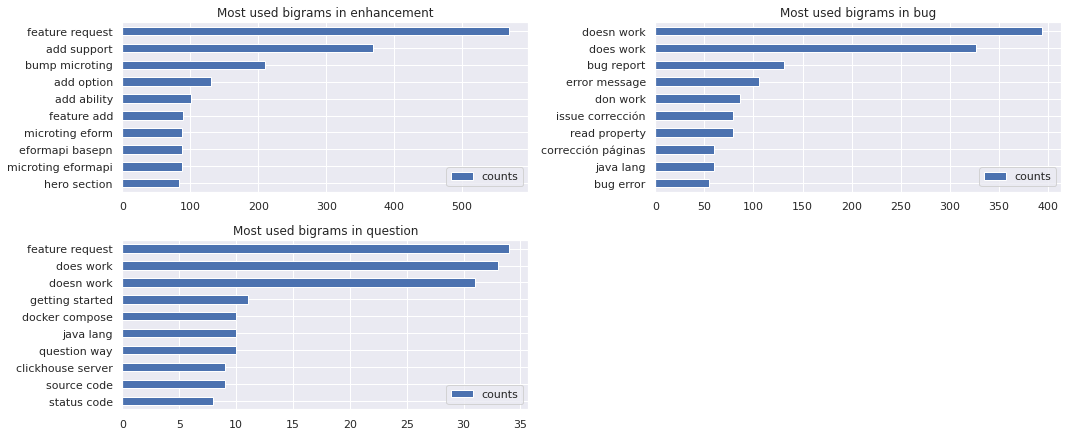

In [260]:
bigrams = get_n_grams(df, n_grams = 2, top_n=10, field = 'title')
plot_ngram(bigrams)

Processed enhancement
Processed bug
Processed question


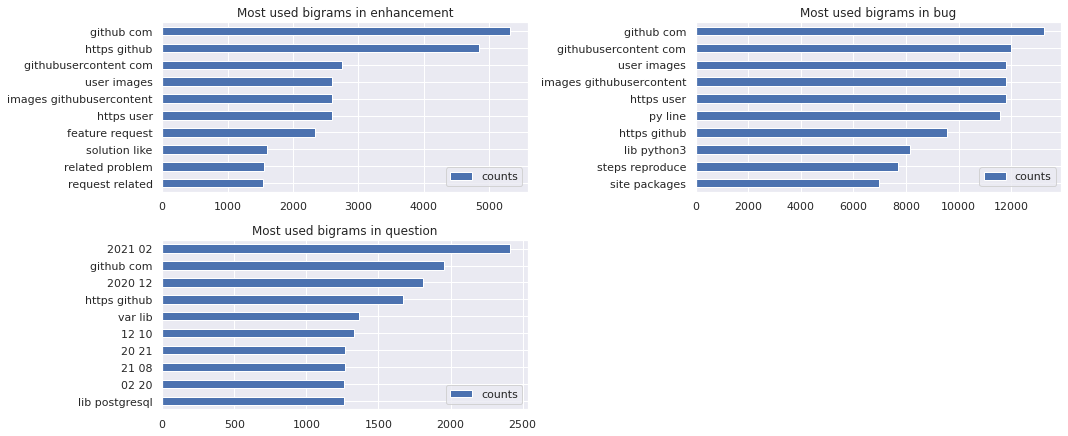

In [261]:
bigrams = get_n_grams(df, n_grams = 2, top_n=10, field = 'body')
plot_ngram(bigrams)

### Observations
- N-grams in title seem to be very relevant!
- N-grams in body are garbage. Will need cleaning?